# Illustrate Tracking Workflow
Show the process of going from image stack to smoothed tracks

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from skimage.transform import AffineTransform, warp
from scipy.interpolate import UnivariateSpline
from imageio import v3 as iio
from pathlib import Path
import pandas as pd
import numpy as np

Configuration

In [2]:
run_dir = Path('../data/8bitTIFF-video26-575C/')
pixel_size = 0.47  # nm/pixel

Derived

In [3]:
run_name = run_dir.name
drift_dir = Path(f'../0_drift-correction/output/{run_name}')
track_dir = Path(f'../1_void-tracking/output/{run_name}')

## Get the Necessary Data
We'll need a bunch of little things, like the paths to the imgaes

In [4]:
images = sorted((run_dir / 'masks').glob('*tif'))

Load the drift tracks produced from the FFT

In [5]:
drift = pd.read_csv(drift_dir / 'drifts-fft.csv')

The void tracks

In [6]:
tracks = pd.read_json(track_dir / 'tracks.json', lines=True)

## Assemble the Big Figure
Going left-to-right:
1. Unaligned images
1. Drift Tracks
1. Aligned Images
1. x-y coordinates of tracks
1. Spline smoothing

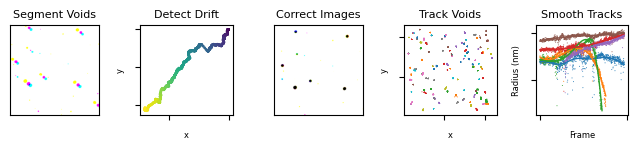

In [9]:
fig, axs = plt.subplots(1, 5, figsize=(6.5, 1.6))
label_size = 6

# Plot the unaligned frames
ax = axs[0]
frames = [120, 240, 480]

image = np.zeros((1024, 1024, 3), dtype=np.uint8) + 255
for i, frame in enumerate(frames):
    mask = iio.imread(images[frame])
    image[:, :, i] -= mask
ax.set_yticks(ax.set_xticks([]))
ax.imshow(image)


# Plot the drift
ax = axs[1]
ax.scatter(drift['x'], drift['y'], c=np.arange(drift.shape[0]), s=1)
ax.set_xlabel('x', fontsize=label_size)
ax.set_ylabel('y', fontsize=label_size)
ax.set_xticklabels([])
ax.set_yticklabels([])


# Plot the aligned images
ax = axs[2]
image = np.zeros((1024, 1024, 3), dtype=np.uint8) + 255
for i, frame in enumerate(frames):
    mask = iio.imread(images[frame])
    affine = AffineTransform(translation=drift.iloc[frame][['x', 'y']])
    mask = np.array(warp(mask, affine) * 255, dtype=np.uint8)
    image[:, :, i] -= mask
ax.set_yticks(ax.set_xticks([]))
ax.imshow(image)


# Plot the Tracks
ax = axs[3]

for gid, group in tracks.query('total_frames > 32').sample(128).iterrows():
    pos = np.array(group['positions'])
    ax.scatter(pos[:, 0], pos[:, 1], s=0.5, ec='none')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xlabel('x', fontsize=label_size)
ax.set_ylabel('y', fontsize=label_size)

# Plot the radius splines
ax = axs[4]
for gid, void in tracks.query('total_frames > 32').sort_values('max_radius').tail(6).iterrows():
    x = np.arange(void['total_frames']) + void['start_frame']
    spline = UnivariateSpline(x, void['radii'])
    ax.scatter(x, np.array(void['radii']) * pixel_size, s=0.5, edgecolor='none')
    ax.plot(x, spline(x) * pixel_size, '-', lw=1)
    
ax.set_xticklabels([])
ax.set_yticklabels([])
    
ax.set_xlabel('Frame', fontsize=label_size)
ax.set_ylabel('Radius (nm)', fontsize=label_size)


# Add the titles
for ax, t in zip(axs, ['Segment Voids', 'Detect Drift', 'Correct Images', 'Track Voids', 'Smooth Tracks']):
    ax.set_title(t, fontsize=8)


fig.tight_layout()
fig.savefig('figures/image-pipeline.png', dpi=320)